In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.gridspec import GridSpec

In [2]:


class EyeDiagramAnalyzer:
    def __init__(self, bits_length=1000, samples_per_bit=32):
        self.samples_per_bit = samples_per_bit
        self.bits = np.random.randint(0, 2, bits_length)
        self.t = np.linspace(0, len(self.bits), len(self.bits) * samples_per_bit)

    def generate_nrz(self, add_noise=False, snr_db=20):
        """Generate Polar NRZ signal"""
        nrz = np.repeat(2 * self.bits - 1, self.samples_per_bit)

        if add_noise:
            signal_power = np.mean(nrz**2)
            noise_power = signal_power / (10**(snr_db/10))
            noise = np.random.normal(0, np.sqrt(noise_power), len(nrz))
            nrz = nrz + noise

        return nrz

    def raised_cosine_pulse(self, alpha=0.35, num_symbols=8):
        """Generate raised cosine pulse"""
        num_points = num_symbols * self.samples_per_bit
        t = np.linspace(-num_symbols/2, num_symbols/2, num_points)

        # Handle the special case at t = 0
        h = np.zeros_like(t)
        h[t == 0] = 1

        # Handle the special case at t = ±1/(2α)
        special_points = np.abs(np.abs(t) - 1/(2*alpha)) < 1e-10
        h[special_points] = (np.pi/4) * np.sinc(1/(2*alpha))

        # Handle all other points
        normal_points = ~(special_points | (t == 0))
        h[normal_points] = np.sinc(t[normal_points]) * \
                          np.cos(np.pi*alpha*t[normal_points]) / \
                          (1 - (2*alpha*t[normal_points])**2)

        return h/np.max(h)

    def generate_raised_cosine(self, alpha=0.35, add_noise=False, snr_db=20):
        """Generate signal with raised cosine pulse shaping"""
        h = self.raised_cosine_pulse(alpha)
        nrz = 2 * self.bits - 1

        upsampled = np.zeros(len(self.bits) * self.samples_per_bit)
        upsampled[::self.samples_per_bit] = nrz

        shaped = np.convolve(upsampled, h, 'same')

        if add_noise:
            signal_power = np.mean(shaped**2)
            noise_power = signal_power / (10**(snr_db/10))
            noise = np.random.normal(0, np.sqrt(noise_power), len(shaped))
            shaped = shaped + noise

        return shaped

    def plot_eye_diagram(self, signal, samples_per_symbol=None):
        """Generate eye diagram for 2Tb"""
        if samples_per_symbol is None:
            samples_per_symbol = self.samples_per_bit

        # Use 2 symbol periods
        period = 2 * samples_per_symbol

        segments = []
        # Overlap segments of 2 symbol periods
        for i in range(len(signal) - period):
            segment = signal[i:i + period]
            segments.append(segment)

        segments = np.array(segments)
        t = np.linspace(0, 2, period)  # Time axis from 0 to 2Tb

        return t, segments

    def plot_all_eye_diagrams(self, signals):
        """Plot eye diagrams for all signals"""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(3, 2, figure=fig)

        for idx, (name, signal) in enumerate(signals.items()):
            ax = fig.add_subplot(gs[idx//2, idx%2])
            t, segments = self.plot_eye_diagram(signal)

            # Plot segments with increased transparency for better visibility
            for segment in segments[::2]:  # Plot every other segment to reduce density
                ax.plot(t, segment, 'b-', alpha=0.05)

            # Add reference lines
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax.axvline(x=1, color='r', linestyle='--', alpha=0.5)

            ax.set_title(f'Eye Diagram: {name}')
            ax.set_xlabel('Symbol Periods (Tb)')
            ax.set_ylabel('Amplitude')
            ax.grid(True, alpha=0.3)

            # Calculate and display eye height
            if 'Noisy' not in name:
                mid_point = len(t)//2
                eye_height = np.percentile(segments[:, mid_point], 95) - \
                            np.percentile(segments[:, mid_point], 5)
                ax.text(0.7, 0.9, f'Eye Height: {eye_height:.2f}',
                       transform=ax.transAxes)

            # Set consistent y-axis limits
            ax.set_xlim(0, 2)
            max_amp = np.max(np.abs(segments))
            ax.set_ylim(-max_amp*1.2, max_amp*1.2)

        plt.tight_layout()
        return fig

    def analyze_signals(self):
        """Generate and analyze different signals"""
        signals = {
            'Clean NRZ': self.generate_nrz(),
            'Noisy NRZ (15dB)': self.generate_nrz(add_noise=True, snr_db=15),
            'Raised Cosine (α=0)': self.generate_raised_cosine(alpha=0.001),  # Small alpha instead of 0
            'Raised Cosine (α=0.35)': self.generate_raised_cosine(alpha=0.35),
            'Raised Cosine (α=1)': self.generate_raised_cosine(alpha=1),
            'Noisy RC (α=0.35, 15dB)': self.generate_raised_cosine(alpha=0.35, add_noise=True, snr_db=15)
        }

        return signals

    def plot_pulse_shapes(self):
        """Plot different pulse shapes for comparison"""
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create time vector with proper length
        num_symbols = 8
        t = np.linspace(-num_symbols/2, num_symbols/2, num_symbols * self.samples_per_bit)

        # Generate pulses with matching dimensions
        rc_0 = self.raised_cosine_pulse(alpha=0.001)  # Small alpha instead of 0
        rc_35 = self.raised_cosine_pulse(alpha=0.35)
        rc_1 = self.raised_cosine_pulse(alpha=1)

        # Plot
        ax.plot(t, rc_0, 'b-', label='α ≈ 0 (Sinc)')
        ax.plot(t, rc_35, 'r-', label='α = 0.35')
        ax.plot(t, rc_1, 'g-', label='α = 1')

        ax.set_title('Raised Cosine Pulse Shapes')
        ax.set_xlabel('Time (T)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        ax.legend()

        return fig





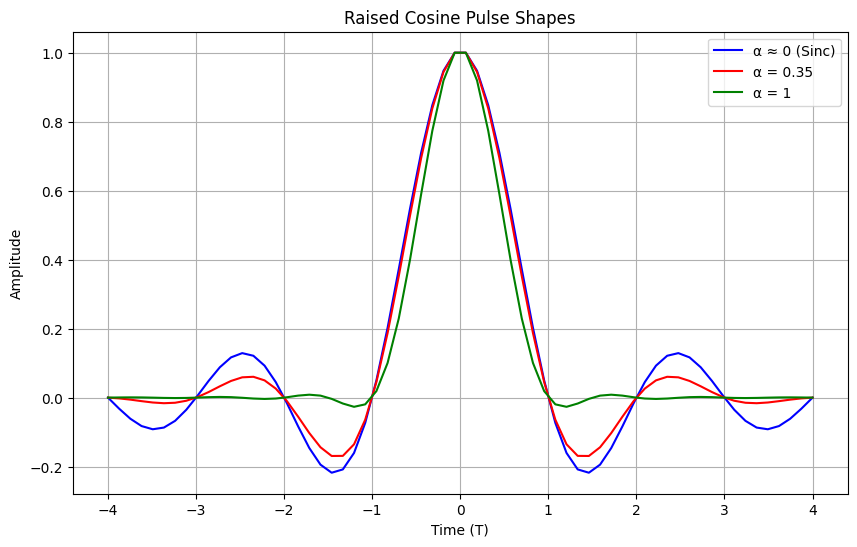

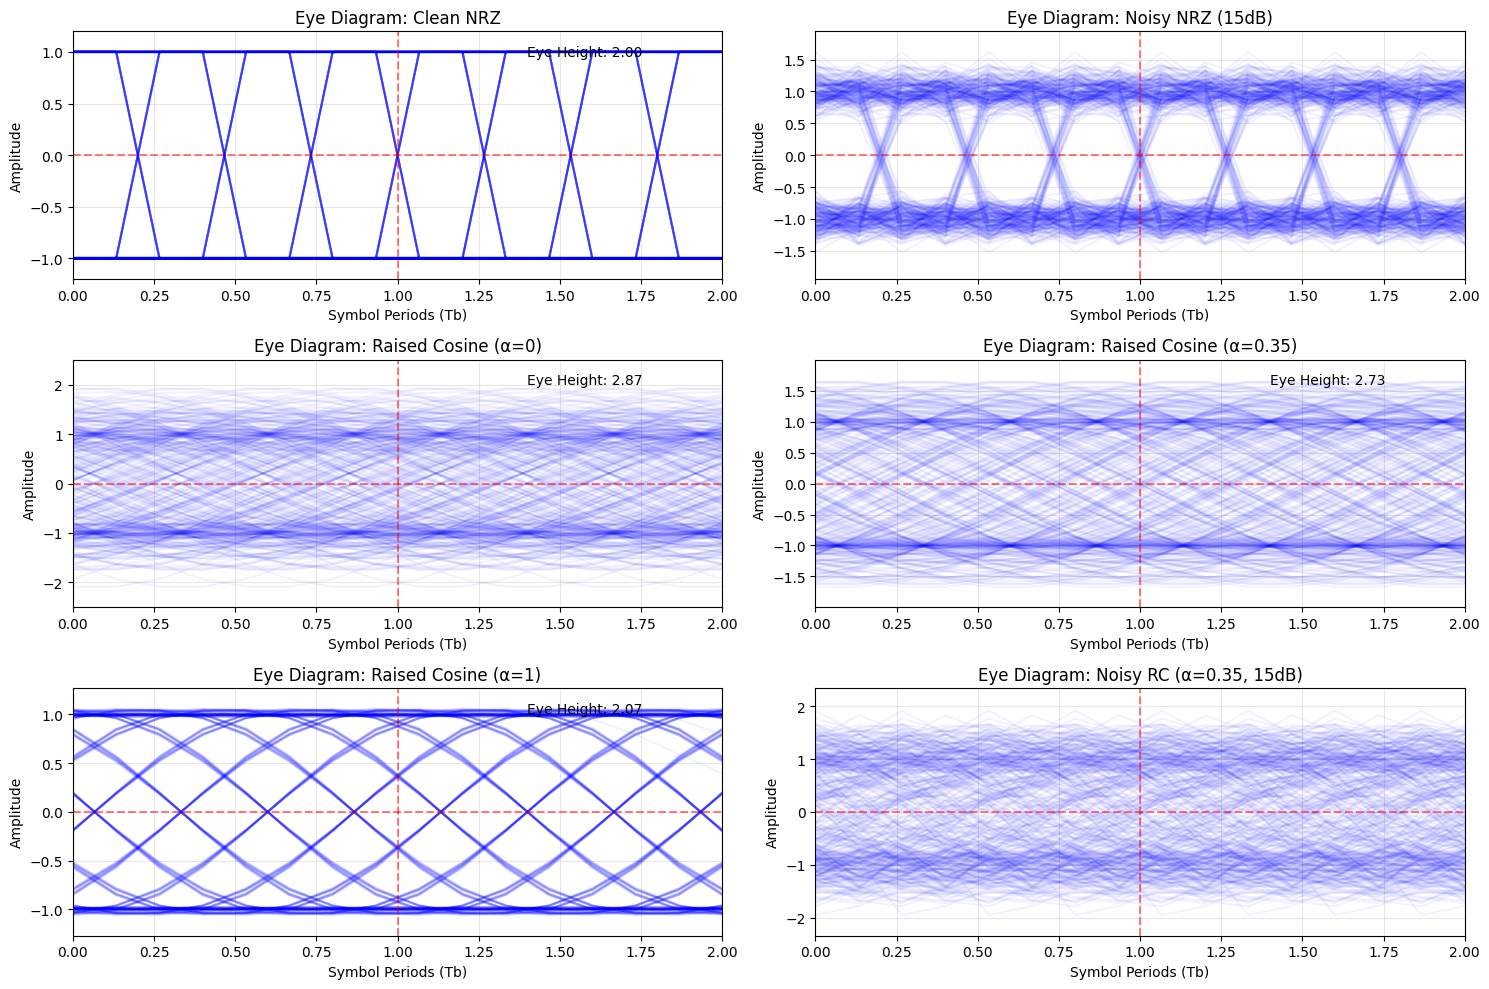


Key Observations for Students:
1. Clean NRZ:
   - Widest eye opening
   - Sharp transitions
   - No ISI at sampling points

2. Noisy NRZ:
   - Vertical eye closure due to noise
   - Timing jitter visible in transitions
   - Decision threshold margin reduced

3. Raised Cosine (α≈0):
   - Theoretical minimum bandwidth
   - More gradual transitions
   - Meets Nyquist criterion

4. Raised Cosine (α=0.35):
   - Industry standard roll-off
   - Good balance of bandwidth and ISI
   - Smoother transitions than NRZ

5. Raised Cosine (α=1):
   - Widest bandwidth
   - Lowest ISI
   - Most gradual transitions

6. Noisy Raised Cosine:
   - Combined effects of ISI and noise
   - Realistic representation of practical systems
   - Demonstrates need for timing recovery


In [3]:
if __name__ == "__main__":
    # Create analyzer instance
    analyzer = EyeDiagramAnalyzer(bits_length=100, samples_per_bit=8)

    # Generate and analyze signals
    signals = analyzer.analyze_signals()

    # Plot pulse shapes
    pulse_fig = analyzer.plot_pulse_shapes()
    plt.figure(pulse_fig.number)
    plt.show()

    # Plot eye diagrams
    eye_fig = analyzer.plot_all_eye_diagrams(signals)
    plt.figure(eye_fig.number)
    plt.show()

    print("\nKey Observations for Students:")
    print("1. Clean NRZ:")
    print("   - Widest eye opening")
    print("   - Sharp transitions")
    print("   - No ISI at sampling points")

    print("\n2. Noisy NRZ:")
    print("   - Vertical eye closure due to noise")
    print("   - Timing jitter visible in transitions")
    print("   - Decision threshold margin reduced")

    print("\n3. Raised Cosine (α≈0):")
    print("   - Theoretical minimum bandwidth")
    print("   - More gradual transitions")
    print("   - Meets Nyquist criterion")

    print("\n4. Raised Cosine (α=0.35):")
    print("   - Industry standard roll-off")
    print("   - Good balance of bandwidth and ISI")
    print("   - Smoother transitions than NRZ")

    print("\n5. Raised Cosine (α=1):")
    print("   - Widest bandwidth")
    print("   - Lowest ISI")
    print("   - Most gradual transitions")

    print("\n6. Noisy Raised Cosine:")
    print("   - Combined effects of ISI and noise")
    print("   - Realistic representation of practical systems")
    print("   - Demonstrates need for timing recovery")